In [1]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import warnings 
from netCDF4 import default_fillvals
from scipy.stats import hmean
import pandas as pd 
from collections import OrderedDict

from string import ascii_uppercase

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl

import matplotlib.patches as mpatches
import seaborn as sns

from rasm_plotting_functions import draw_map, plot_n_std_anoms

# RASM lib plotting utilities
from rasmlib.calendar import dpm
from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import (cmap_discretize, sub_plot_pcolor, projections, 
                                       default_map, make_bmap, seasons)

In [2]:
plot_direc = '/p/home/gergel/plots/rasm_meeting_may2019'

truncate runs - specify beginning and end dates

`R1950VIC5aRBRcaaa01a` to be compared with `R2103aRBRcaaa01a` (a runs) 

1979 - 2008, lop off first ten years, so 1990 - 2008

`R1950VIC5aRBRcaaa02a` to be compared with `R2104aRBRcvic01a` (b runs)

2000 - 2009, analyze entire run 

In [3]:
ncfiles = {}

ncdata = {}
# Grid and domain files
# need to update paths on these files and make sure they are correctly ported over
ncfiles['rasm_domain'] = os.path.join('/p/home/gergel/data/RASM_land_masks', 
                                      'domain.lnd.wr50a_ar9v4.100920.nc')
ncfiles['rasm_masks'] = os.path.join('/p/home/gergel/data/RASM_land_masks',
                                     'RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc')
ncfiles['rasm_domain_vic5'] = os.path.join('/p/home/gergel/data/parameters/',
                                           'domain.lnd.wr50a_ar9v4.130607.nc')

ncdata['rasm_domain'] = xr.open_dataset(ncfiles['rasm_domain'])
ncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])
ncdata['rasm_domain_vic5'] = xr.open_dataset(ncfiles['rasm_domain_vic5'])

In [4]:
beg_runa = '1990-09'
end_runa = '2008-09'
ncdata['RASM 2.1a'] = xr.open_dataset(
    os.path.join('/p/work1/gergel/rasm_meeting_may2019/R2103aRBRcaaa01a', 
                'R2103aRBRcaaa01a.vic.hmm.197909-201612.nc'))
ncdata['RASM 2.1a'] = ncdata['RASM 2.1a'].loc[dict(time=slice(beg_runa, end_runa))]

beg_runb = '2000-09'
end_runb = '2009-09'
ncdata['RASM 2.1b'] = xr.open_dataset(
    os.path.join('/p/work1/gergel/rasm_meeting_may2019/R2104aRBRcvic01a', 
                'R2104aRBRcvic01a.vic.hmm.199709-201612.nc'))
ncdata['RASM 2.1b'] = ncdata['RASM 2.1b'].loc[dict(time=slice(beg_runb, end_runb))]

In [5]:
direc_run1 = '/p/work1/gergel/rasm_meeting_may2019/R1950VIC5aRBRcaaa01a/lnd/hist'
ncdata['RASM VIC5a'] = xr.open_mfdataset(os.path.join(direc_run1, 
                                                     'R1950VIC5aRBRcaaa01a*'))
ncdata['RASM VIC5a'] = ncdata['RASM VIC5a'].loc[dict(time=slice(beg_runa, end_runa))]

# to deal with duplicate time entries, use solution suggested by Keisuke Fujii here: 
# https://stackoverflow.com/questions/51058379/drop-duplicate-times-in-xarray
_, index = np.unique(ncdata['RASM VIC5a']['time'], return_index=True)
ncdata['RASM VIC5a'] = ncdata['RASM VIC5a'].isel(time=index)

In [6]:
direc_run2 = '/p/work1/gergel/rasm_meeting_may2019/R1950VIC5aRBRcaaa02a'
ncdata['RASM VIC5b'] = xr.open_mfdataset(os.path.join(direc_run2, 
                                                     'R1950VIC5aRBRcaaa02a*'))
ncdata['RASM VIC5b'] = ncdata['RASM VIC5b'].loc[dict(time=slice(beg_runb, end_runb))]

# to deal with duplicate time entries, use solution suggested by Keisuke Fujii here: 
# https://stackoverflow.com/questions/51058379/drop-duplicate-times-in-xarray
_, index = np.unique(ncdata['RASM VIC5b']['time'], return_index=True)
ncdata['RASM VIC5b'] = ncdata['RASM VIC5b'].isel(time=index)

In [7]:
# era_interim_ts1 has radiation and precip 
era_direc = '/p/work1/gergel/rasm_meeting_may2019/era-interim'
ncdata['era_interim_ts1'] = xr.open_dataset(os.path.join(era_direc,
                                                         'wrf-197909-201212.era_i.nc'))
# era_interim_ts2 has tair
ncdata['era_interim_ts2'] = xr.open_dataset(os.path.join(era_direc,
                                                         'met_em-197909-201212.nc'))

# era_interim_ts3 has water vars
ncdata['era_interim_ts3'] = xr.open_dataset(os.path.join(era_direc,
                                                         'era_water_vars.1979-2014.nc'))

In [8]:
# Rename variables in datasets as necessary
name_dicts = {'era_interim_ts1': {'rsus': 'Swup',
                                  'rsds': 'Swin',
                                  'rlus': 'Lwup',
                                  'rlds': 'Lwin',
                                  'hfss': 'Senht',
                                  'hfls': 'Latht',
                                  'snow_depth': 'Swq',
                                  'precip_tot': 'Precipitation',
                                  'LW_deac_net': 'Lwnet',
                                  'SW_deac_net': 'Swnet',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_interim_ts2': {'T_2m': 'Tair',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_interim_ts3': {'tp': 'Precipitation',
                                  'e': 'Evap',
                                  'ro': 'Runoff'}, 
              'RASM VIC5a': {'OUT_RUNOFF': 'Runoff', 
                            'OUT_BASEFLOW': 'Baseflow',  
                            'OUT_EVAP': 'Evap', 
                            'OUT_AIR_TEMP': 'Tair', 
                            'OUT_LATENT': 'Latht', 
                            'OUT_SENSIBLE': 'Senht', 
                            'OUT_LWDOWN': 'Lwin', 
                            'OUT_SWDOWN': 'Swin', 
                            'OUT_SWE': 'Swq', 
                            'OUT_LWNET': 'Lwnet', 
                            'OUT_SWNET': 'Swnet', 
                            'OUT_R_NET': 'Netrad'}, 
              'RASM VIC5b': {'OUT_RUNOFF': 'Runoff', 
                            'OUT_BASEFLOW': 'Baseflow',  
                            'OUT_EVAP': 'Evap', 
                            'OUT_AIR_TEMP': 'Tair', 
                            'OUT_LATENT': 'Latht', 
                            'OUT_SENSIBLE': 'Senht', 
                            'OUT_LWDOWN': 'Lwin', 
                            'OUT_SWDOWN': 'Swin', 
                            'OUT_SWE': 'Swq', 
                            'OUT_LWNET': 'Lwnet', 
                            'OUT_SWNET': 'Swnet', 
                            'OUT_R_NET': 'Netrad'}}

for k, v in ncdata.items():
    if k in name_dicts:
        print(k)
        v.rename(name_dicts[k], inplace=True)
        
''''OUT_AIR_TEMP': 'Tair', 
                            'OUT_LATENT': 'Latht', 
                            'OUT_SENSIBLE': 'Senht'}'''

RASM VIC5a
RASM VIC5b
era_interim_ts1
era_interim_ts2
era_interim_ts3


"'OUT_AIR_TEMP': 'Tair', \n                            'OUT_LATENT': 'Latht', \n                            'OUT_SENSIBLE': 'Senht'}"

In [9]:
# ncdata['RASM VIC5a']

In [10]:
# add variables or adjust units of datasets if necessary for RASM data
for r in ['RASM 2.1a','RASM 2.1b','RASM VIC5a', 'RASM VIC5b']: 
    ncdata[r]['runoff_tot'] = ncdata[r]['Runoff'] + ncdata[r]['Baseflow']
    # ncdata[r]['runoff_ratio'] = ncdata[r]['runoff_tot'] / ncdata[r]['Precipitation']
    # ncdata[r]['P-E'] = ncdata[r]['Precipitation'] - ncdata[r]['Evap']
    
# adjust units of variables for ERA-Interim
ncdata['era_interim_ts1']['calc_albedo'] = ncdata['era_interim_ts1']['Swup'] / ncdata['era_interim_ts1']['Swin']
ncdata['era_interim_ts1']['Swnet'] = ncdata['era_interim_ts1']['Swin'] - ncdata['era_interim_ts1']['Swup']
ncdata['era_interim_ts1']['Lwnet'] = ncdata['era_interim_ts1']['Lwin'] - ncdata['era_interim_ts1']['Lwup']
ncdata['era_interim_ts1']['Radnet'] = ncdata['era_interim_ts1']['Swnet'] + ncdata['era_interim_ts1']['Lwnet']
ncdata['era_interim_ts1']['Radin'] = ncdata['era_interim_ts1']['Swin'] + ncdata['era_interim_ts1']['Lwin']
ncdata['era_interim_ts1']['bowen_ratio'] = ncdata['era_interim_ts1']['Senht'] / ncdata['era_interim_ts1']['Latht']
ncdata['era_interim_ts1']['evap_frac'] = 1 / (1 + ncdata['era_interim_ts1']['bowen_ratio'])
for var in ('Runoff', 'Precipitation'):
    ncdata['era_interim_ts3'][var] *= 1000.
ncdata['era_interim_ts3']['Evap'] *= -1000.
ncdata['era_interim_ts3'] = ncdata['era_interim_ts3'].resample('MS', how='mean', dim='time')
ncdata['era_interim_ts3']['runoff_tot'] = ncdata['era_interim_ts3']['Runoff']
ncdata['era_interim_ts3']['runoff_ratio'] = (ncdata['era_interim_ts3']['runoff_tot'] / 
                                             ncdata['era_interim_ts3']['Precipitation'])
ncdata['era_interim_ts3']['P-E'] = ncdata['era_interim_ts3']['Precipitation'] - ncdata['era_interim_ts3']['Evap']

In [11]:
# Setup rasmlib plotting
wr50a_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['rasm_domain']['xc'].values,
                      lats=ncdata['rasm_domain']['yc'].values)
ncdata['rasm_masks'] = xr.open_mfdataset(ncfiles['rasm_masks'])
spatial_plot_mask = ncdata['rasm_masks']['mask_active_land'].values < 0.9

#pop_masks = xr.open_dataset('/p/cwfs/gergel/compare_data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc')
#wrf_masks = xr.open_dataset('/p/cwfs/gergel/compare_data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc')

set plot preferences

In [12]:
sns.set_style("white")

# Set some general plotting values
fontsize = 12
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

fill_color = (0.9, 0.9, 0.9)

samin, samax = -11, 11

In [13]:
var = 'runoff_tot'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts3'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts3'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

In [14]:
def draw_map(lw=0.3):
    wr50a_map.m.drawmapboundary(fill_color=(0.9, 0.9, 0.9))
    wr50a_map.m.fillcontinents(color='white', zorder=0)
    wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=lw)
    wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=lw)
    wr50a_map.m.drawcoastlines(color='k', linewidth=lw)

def plot_era_anoms(monthly_means, season_anoms_era_vic5, annual_anoms_era_vic5, vmin=-25, vmax=25, 
                   smin=0, smax=3, amin=-4.5, amax=4.5,
                   cmap='Spectral_r', smap='YlGnBu', amap='RdBu', cbar_extend='both',
                   sbar_extend='max', abar_extend='both', cbar_label= 'Mean', era_interim=True,
                   varname=None, units='-'):
    with sns.axes_style("white"):

        # Set colorbar norms and ticks
        cn = 10
        cmap = cmap_discretize(cmap, n_colors=cn)
        cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cticks = np.linspace(vmin, vmax, num=cn + 1)
        cn = 10
        an = 9
        amap = cmap_discretize(amap, n_colors=an)
        anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
        aticks = np.round(np.linspace(amin, amax, num=an + 1), 1)

        keys = list(monthly_means.keys())
        
        dss_era = monthly_means[keys[0]].resample('QS-SEP', dim='time').groupby('time.season')
        dsa_era = monthly_means[keys[0]].resample('AS', dim='time')
        
        ncols = 5
        width = 11
        
        nrows = 3
        
        height = 1.55 * nrows + 0.6
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                 figsize=(width, height),
                                 sharex=True, sharey=True)
        plt.subplots_adjust(left=0.125, bottom=0.05,
                            right=0.9, top=0.9,
                            wspace=0.05, hspace=0.05)
        
        # ERA-Interim means
        season_means_era = dss_era.mean(dim='time')
        annual_means_era = dsa_era.mean(dim='time')
        
        # seasonal/annual means for ERA-Interim as top row
        # ERA-Interim
        for i, season in enumerate(seasons):
            plt.sca(axes[0, i])
            draw_map()
            sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_means_era.sel(season=season).to_masked_array()),
                            map_obj=wr50a_map, cbar=None, vmin=vmin, vmax=vmax, cmap=cmap, ax=axes[0, i])


        plt.sca(axes[0, 4])
        draw_map()
        sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_means_era.to_masked_array()),
                        map_obj=wr50a_map, cbar=None, vmin=vmin, vmax=vmax, cmap=cmap, ax=axes[0, 4])

        # anomalies for RASM baseline run 
        count = 1
        for j, key in enumerate(keys[1:]):
            print(key)
            if key == 'RASM VIC5a' or key == 'RASM VIC5b':
                # plot seasonal anomalies
                for i, season in enumerate(seasons):
                    plt.sca(axes[count, i])
                    draw_map()
                    sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_anoms_era_vic5.sel(season=season).to_masked_array()),
                                    map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap, ax=axes[count, i])

                # plot annual anomalies
                plt.sca(axes[count, 4])
                draw_map()
                sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_anoms_era_vic5.to_masked_array()),
                                map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap, ax=axes[count, 4])
            else: 
                # calculate seasonal means for this dataset
                dss = monthly_means[key].resample('QS-SEP', dim='time').groupby('time.season')
                dss_mean = dss.mean(dim='time')
            
                # calculate annual means for this dataset
                dsa = monthly_means[key].resample('AS', dim='time')
                dsa_mean = dsa.mean(dim='time')
            
                # SEASONAL MEANS
                # calculate difference between seasonal means for ERA-Interim and this dataset
                season_anoms_era = dss_mean - season_means_era
            
                # ANNUAL MEANS
                # calculate difference between annual means for ERA-Interim and this dataset 
                annual_anoms_era = dsa_mean - annual_means_era

                # plot seasonal anomalies
                for i, season in enumerate(seasons):
                    plt.sca(axes[count, i])
                    draw_map()
                    sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_anoms_era.sel(season=season).to_masked_array()),
                                    map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap, ax=axes[count, i])

                # plot annual anomalies
                plt.sca(axes[count, 4])
                draw_map()
                sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_anoms_era.to_masked_array()),
                                map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap, ax=axes[count, 4])
            
            count += 1


        plt.tight_layout()

        # titles = [ax.set_title(str(title)) for title, ax in zip(list(seasons) + ['Annual'], axes[0])]
        new_seasons = list(seasons) + ['Annual']
        for i, ax in enumerate(axes[0]):
            ax.set_title(new_seasons[i])
        # ylabels = [ax.set_ylabel("{0}\n — {1}".format(keys[0], label)) for label, ax in zip(keys[1:], axes[2:, 0])]
        for label, ax in zip(keys[1:], axes[2:, 0]): 
            # ax.set_ylabel("{0}\n — {1}".format(keys[0], label))
            ax.set_ylabel("%s \n - %s" % (keys[0], label))
        # axes[0, 0].set_ylabel(keys[0])
        # axes[1, 0].set_ylabel("{0} (Std.)".format(keys[0]))
        axes[0, 0].set_ylabel("%s" % keys[0])
        
        axes[1, 0].set_ylabel("%s \n - %s" % (keys[1], keys[0]))
        axes[2, 0].set_ylabel("%s \n - %s" % (keys[2], keys[0]))
        # axes[3, 0].set_ylabel("%s \n - %s" % (keys[0], keys[3]))

        # Colorbars
        cbar_height = 0.02
        # cbar_width = .313
        cbar_width = 0.47
        ax1 = fig.add_axes([0.01, -cbar_height, cbar_width, cbar_height])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                        orientation='horizontal',
                                        extend=cbar_extend,
                                        ticks=cticks)
        
        ax3 = fig.add_axes([0.5, -cbar_height, cbar_width, cbar_height])
        cb3 = mpl.colorbar.ColorbarBase(ax3, cmap=amap, norm=anorm,
                                        orientation='horizontal',
                                        extend=abar_extend,
                                        ticks=aticks)
        if varname is not None:
            cb1.set_label("{0} ({1}, Mean)".format(varname, units))
            # cb2.set_label("{0} ({1}, Std.)".format(varname, units))
            cb3.set_label("{0} ({1}, Anomaly)".format(varname, units))

    return fig, axes

RASM 2.1a
RASM VIC5a


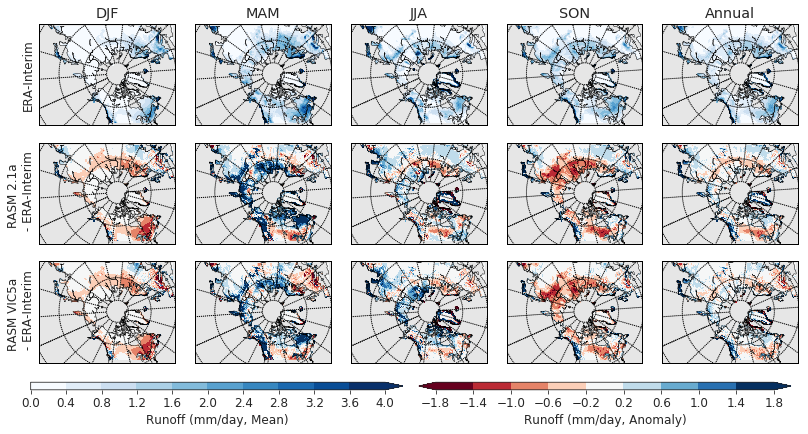

In [15]:
# plot_era_anoms
var = 'runoff_tot'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts3'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=0, vmax=4, 
                           amin=-1.8, amax=1.8, cmap='Blues',
                           amap='RdBu', cbar_extend='max',
                           varname='Runoff', units='mm/day', era_interim=True)

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


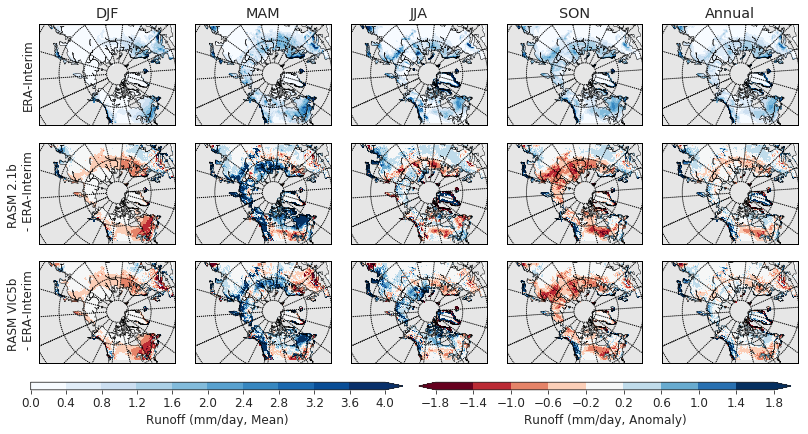

In [16]:
# plot_era_anoms
var = 'runoff_tot'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts3'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=0, vmax=4, 
                           amin=-1.8, amax=1.8, cmap='Blues',
                           amap='RdBu', cbar_extend='max',
                           varname='Runoff', units='mm/day', era_interim=True)

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [17]:
var = 'Evap'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts3'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts3'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

RASM 2.1a
RASM VIC5a


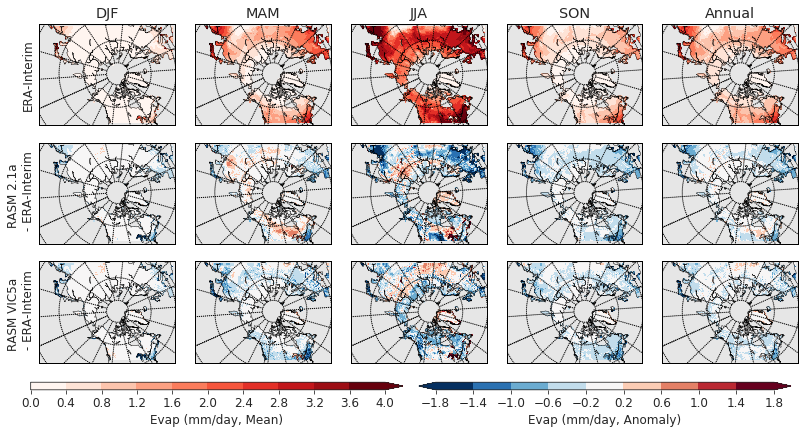

In [18]:
# plot_era_anoms
var = 'Evap'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts3'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=0, vmax=4, 
                           amin=-1.8, amax=1.8, cmap='Reds',
                           amap='RdBu_r', cbar_extend='max',
                           varname='Evap', units='mm/day', era_interim=True)

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


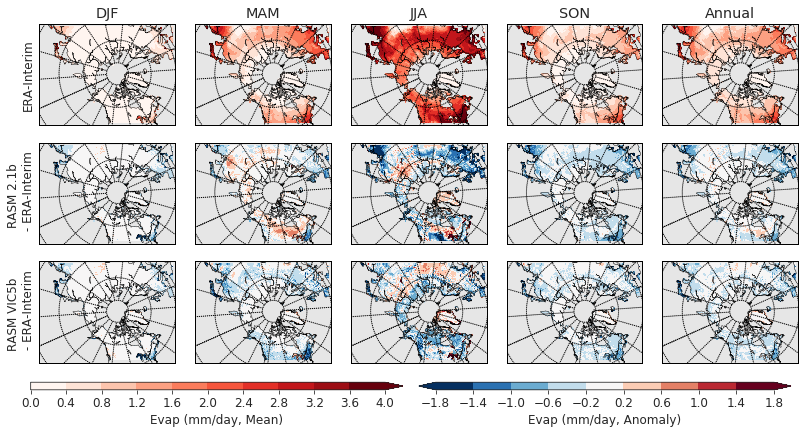

In [19]:
# plot_era_anoms
var = 'Evap'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts3'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=0, vmax=4, 
                           amin=-1.8, amax=1.8, cmap='Reds',
                           amap='RdBu_r', cbar_extend='max',
                           varname='Evap', units='mm/day', era_interim=True)

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [20]:
var = 'Tair'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts2'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts2'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

RASM 2.1a
RASM VIC5a


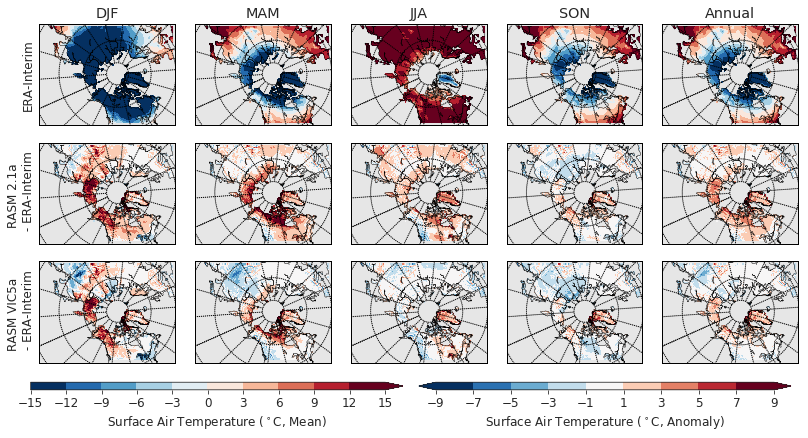

In [21]:
# plot_era_anoms
var = 'Tair'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts2'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

# amin=-9, amax=9, smax=5, amap='RdBu_r',

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=-15, vmax=15, 
                           amin=-9, amax=9, cmap='RdBu_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Surface Air Temperature', units='$^\circ C$')

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


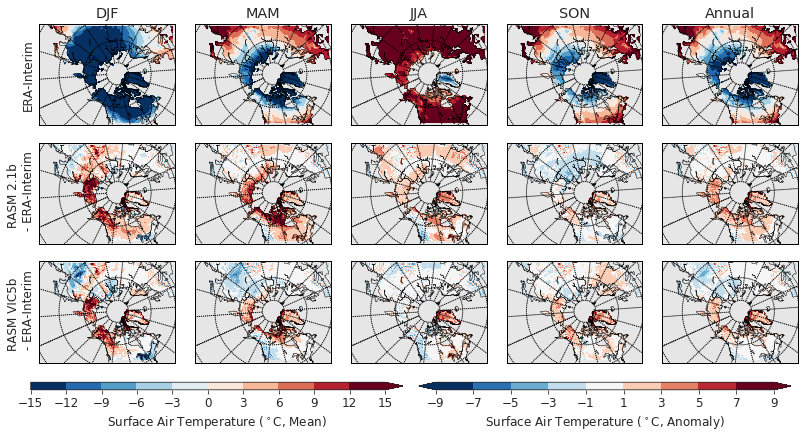

In [22]:
# plot_era_anoms
var = 'Tair'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts2'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

# amin=-9, amax=9, smax=5, amap='RdBu_r',

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=-15, vmax=15, 
                           amin=-9, amax=9, cmap='RdBu_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Surface Air Temperature', units='$^\circ C$')

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [23]:
var = 'Latht'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts1'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts1'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

RASM 2.1a
RASM VIC5a


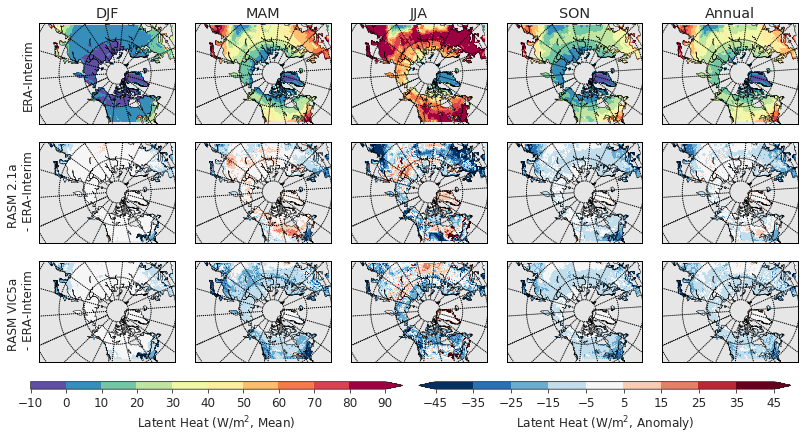

In [24]:
# plot_era_anoms
var = 'Latht'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=-10, vmax=90, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Latent Heat', units='$W/m^2$')

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


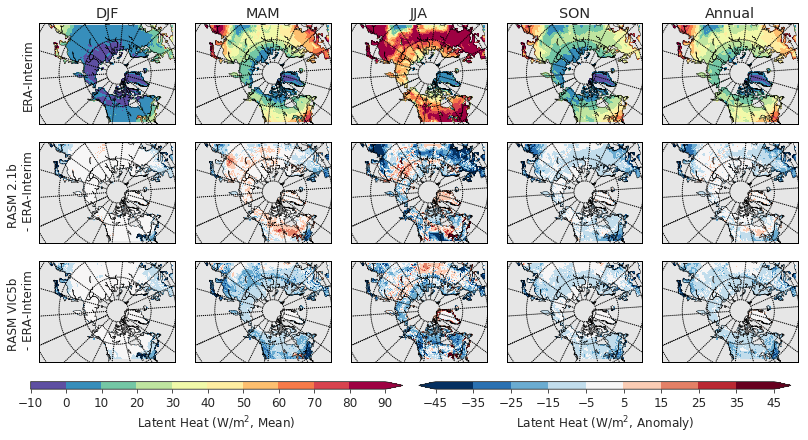

In [25]:
# plot_era_anoms
var = 'Latht'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=-10, vmax=90, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Latent Heat', units='$W/m^2$')

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [26]:
var = 'Senht'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts1'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts1'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

RASM 2.1a
RASM VIC5a


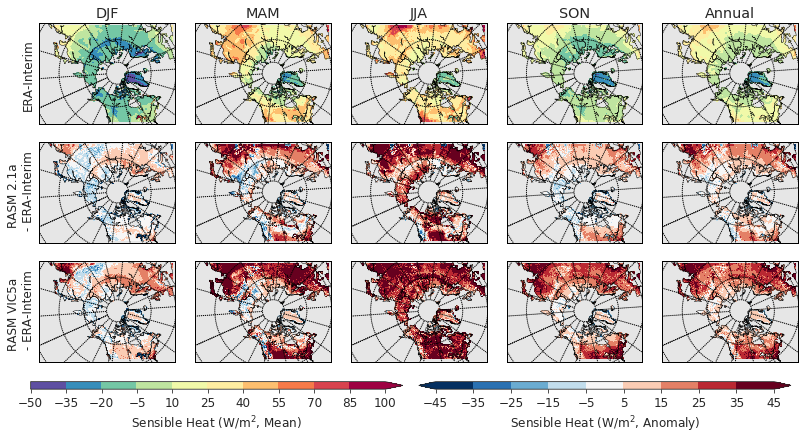

In [27]:
# plot_era_anoms
var = 'Senht'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=-50, vmax=100, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Sensible Heat', units='$W/m^2$')

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


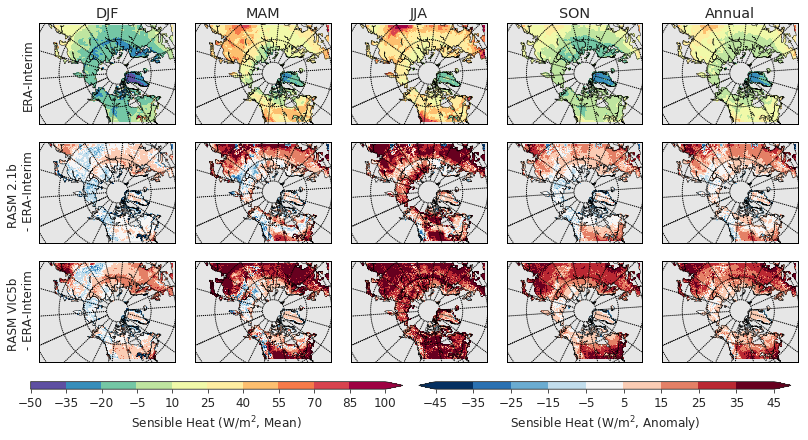

In [28]:
# plot_era_anoms
var = 'Senht'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=-50, vmax=100, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Sensible Heat', units='$W/m^2$')

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [29]:
var = 'Lwnet'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts1'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts1'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

RASM 2.1a
RASM VIC5a


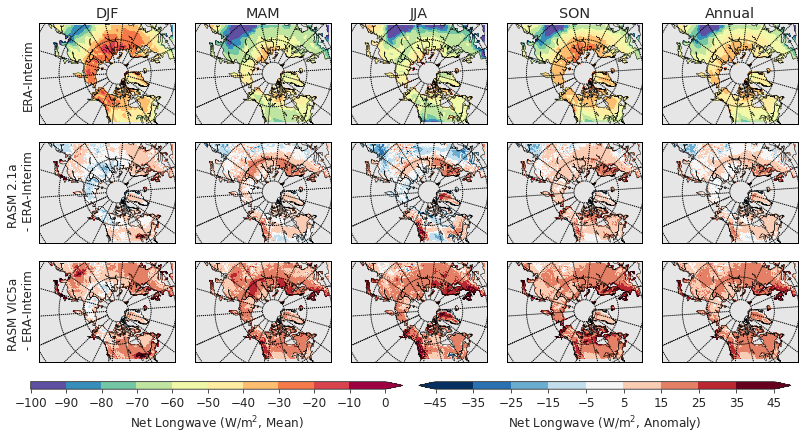

In [30]:
# plot_era_anoms
var = 'Lwnet'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=-100, vmax=0, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Net Longwave', units='$W/m^2$')

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


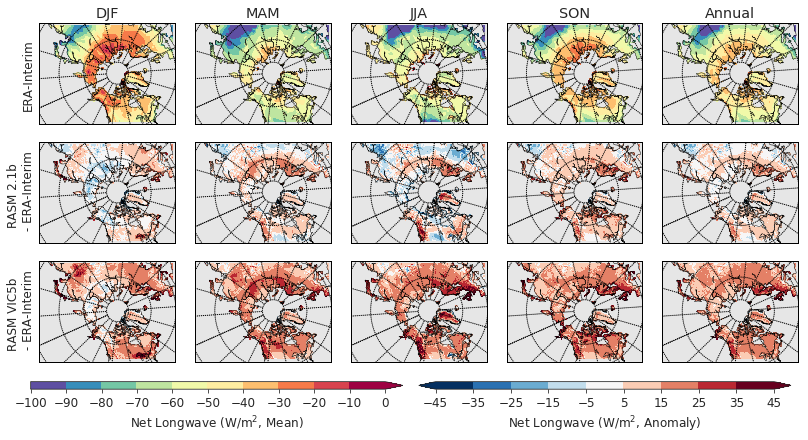

In [31]:
# plot_era_anoms
var = 'Lwnet'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=-100, vmax=0, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Net Longwave', units='$W/m^2$')

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [32]:
var = 'Swnet'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts1'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts1'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

RASM 2.1a
RASM VIC5a


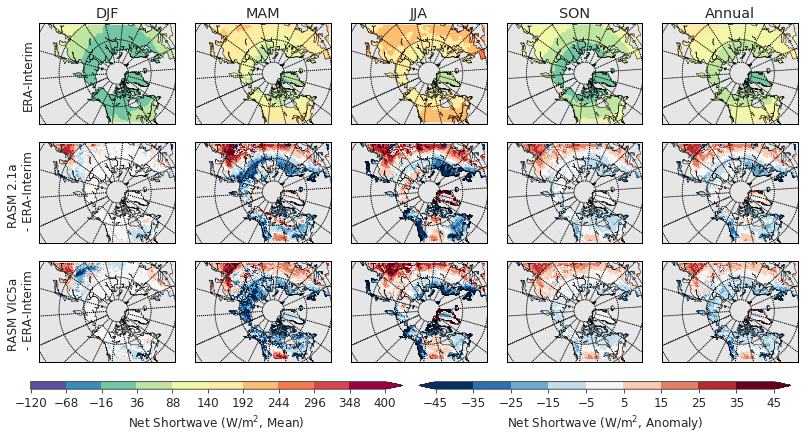

In [33]:
# plot_era_anoms
var = 'Swnet'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=-120, vmax=400, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Net Shortwave', units='$W/m^2$')

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


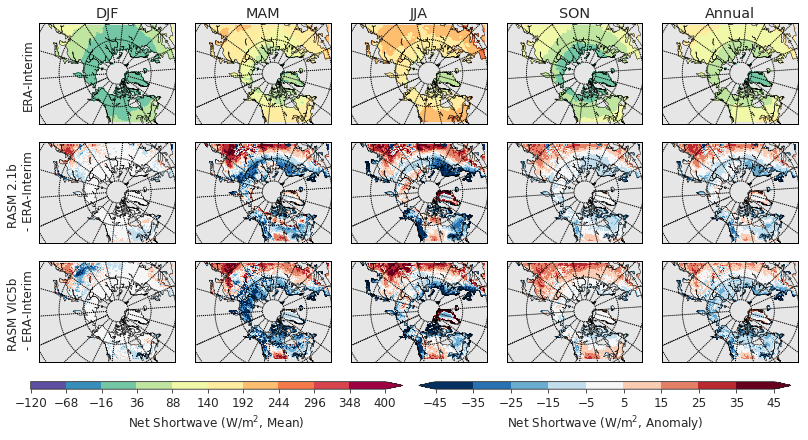

In [34]:
# plot_era_anoms
var = 'Swnet'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=-120, vmax=400, 
                           amin=-45, amax=45, cmap='Spectral_r',
                           amap='RdBu_r', cbar_extend='max',
                           era_interim=True, 
                           varname='Net Shortwave', units='$W/m^2$')

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [35]:
var = 'Swq'
### ERA-INTERIM
dss_era = ncdata['era_interim_ts1'][var].resample('QS-SEP', dim='time').groupby('time.season')
dsa_era = ncdata['era_interim_ts1'][var].resample('AS', dim='time')

season_means_era = dss_era.mean(dim='time')
annual_means_era = dsa_era.mean(dim='time')

### RASM with VIC 5
dss_a = ncdata['RASM VIC5a'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5a = dss_a.mean(dim='time')

dsa_a = ncdata['RASM VIC5a'][var].resample('AS', dim='time')
annual_means_vic5a = dsa_a.mean(dim='time')

dss_b = ncdata['RASM VIC5b'][var].resample('QS-SEP', dim='time').groupby('time.season')
season_means_vic5b = dss_b.mean(dim='time')

dsa_b = ncdata['RASM VIC5b'][var].resample('AS', dim='time')
annual_means_vic5b = dsa_b.mean(dim='time')

### DIFFERENCES
# SEASONAL MEANS
season_anoms_era_vic5a = season_means_vic5a - season_means_era.rename({'x': 'ni', 'y': 'nj'})
season_anoms_era_vic5b = season_means_vic5b - season_means_era.rename({'x': 'ni', 'y': 'nj'})

# ANNUAL MEANS
annual_anoms_era_vic5a = annual_means_vic5a - annual_means_era.rename({'x': 'ni', 'y': 'nj'})
annual_anoms_era_vic5b = annual_means_vic5b - annual_means_era.rename({'x': 'ni', 'y': 'nj'})

RASM 2.1a
RASM VIC5a


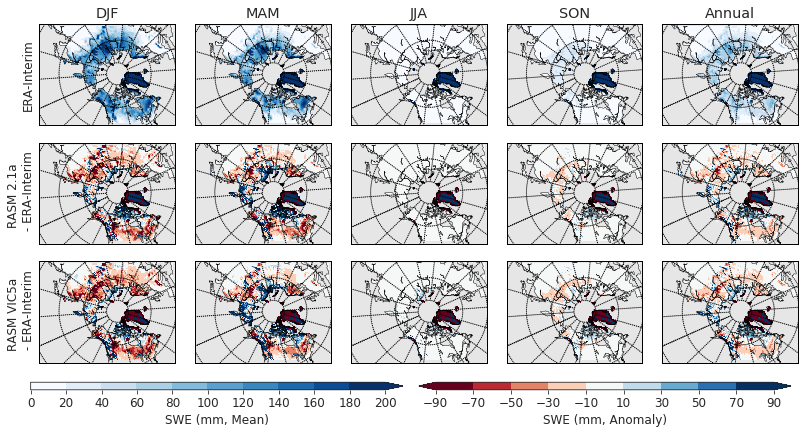

In [36]:
# plot_era_anoms
var = 'Swq'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runa, end_runa))])
monthly_means['RASM 2.1a'] = ncdata['RASM 2.1a'][var]
monthly_means['RASM VIC5a'] = ncdata['RASM VIC5a'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5a, annual_anoms_era_vic5a, 
                           vmin=0, vmax=200, 
                           amin=-90, amax=90, cmap='Blues',
                           amap='RdBu', cbar_extend='max',
                           era_interim=True, 
                           varname='SWE', units='mm')

plotname = '%s_a.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

RASM 2.1b
RASM VIC5b


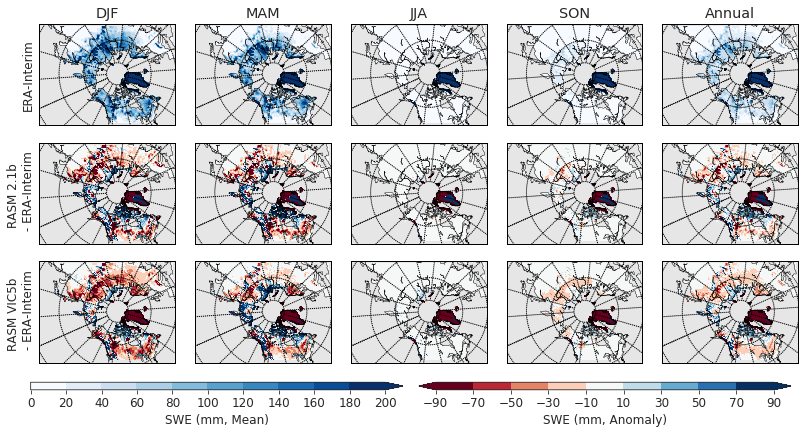

In [37]:
# plot_era_anoms
var = 'Swq'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = (ncdata['era_interim_ts1'][var].
                               loc[dict(time=slice(beg_runb, end_runb))])
monthly_means['RASM 2.1b'] = ncdata['RASM 2.1b'][var]
monthly_means['RASM VIC5b'] = ncdata['RASM VIC5b'][var]

fig, axes = plot_era_anoms(monthly_means, season_anoms_era_vic5b, annual_anoms_era_vic5b, 
                           vmin=0, vmax=200, 
                           amin=-90, amax=90, cmap='Blues',
                           amap='RdBu', cbar_extend='max',
                           era_interim=True, 
                           varname='SWE', units='mm')

plotname = '%s_b.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')